In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
# Load stock data
company = "BTC-USD"
start = dt.date(2012, 1, 1)
end = dt.date.today()

data = web.DataReader(company, "yahoo", start, end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014
...,...,...,...,...,...,...
2022-03-27,46827.546875,44437.292969,44505.355469,46820.492188,28160889722,46820.492188
2022-03-28,48086.835938,46690.203125,46821.851562,47128.003906,36362175703,47128.003906
2022-03-29,48022.289062,47100.437500,47100.437500,47465.730469,31397059069,47465.730469


In [3]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

prediction_days = 60
future_day = 30

X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    X_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [4]:
# Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # prevent overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next closing value

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=25, batch_size=32)

# model.save()

2022-03-31 12:14:30.144803: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25
84/84 [==============================] - 4s 29ms/step - loss: 0.0121
Epoch 2/25
84/84 [==============================] - 3s 34ms/step - loss: 0.0062
Epoch 3/25
84/84 [==============================] - 3s 34ms/step - loss: 0.0059
Epoch 4/25
84/84 [==============================] - 3s 34ms/step - loss: 0.0050
Epoch 5/25
84/84 [==============================] - 3s 34ms/step - loss: 0.0040
Epoch 6/25
84/84 [==============================] - 3s 35ms/step - loss: 0.0039
Epoch 7/25
84/84 [==============================] - 3s 34ms/step - loss: 0.0037
Epoch 8/25
84/84 [==============================] - 3s 35ms/step - loss: 0.0035
Epoch 9/25
84/84 [==============================] - 3s 35ms/step - loss: 0.0034
Epoch 10/25
84/84 [==============================] - 3s 35ms/step - loss: 0.0037
Epoch 11/25
84/84 [==============================] - 3s 35ms/step - loss: 0.0031
Epoch 12/25
84/84 [==============================] - 3s 35ms/step - loss: 0.0033
Epoch 13/25
84/84 [==================

In [5]:
# Test the model accuracy on existing data
# Load Test Data
test_start = dt.date(2020, 1, 1) + dt.timedelta(days=-prediction_days)
test_end = dt.date.today()

test_data = web.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)

model_inputs = total_dataset[
    len(total_dataset) - len(test_data) - prediction_days :
].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


In [6]:
# Make Predictions on Test Data
X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x - prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


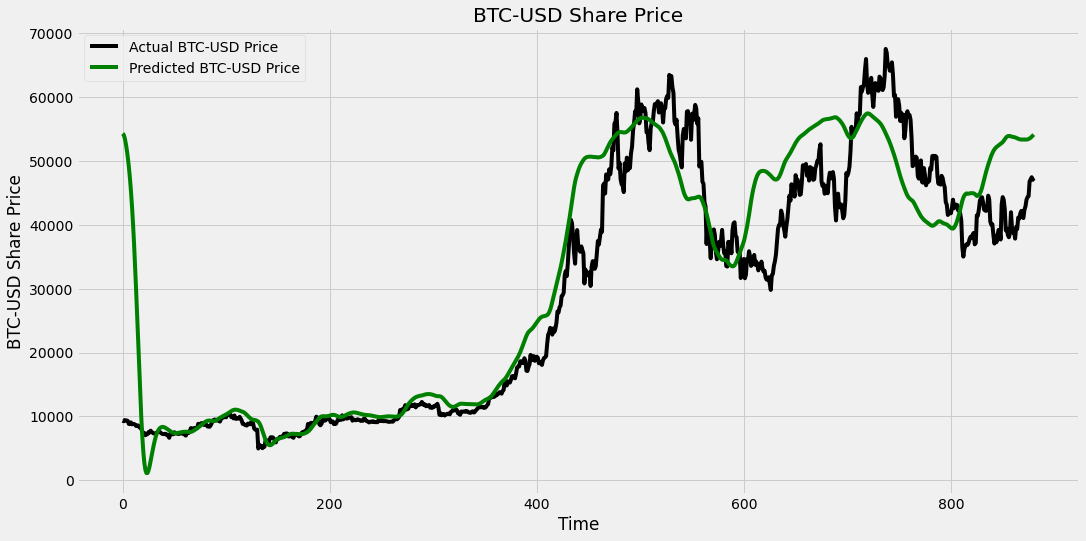

In [7]:
# Plot the test predictions
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend(loc='upper left')
plt.show()
# plt.savefig(f"./plot/{company}_LSTM_predicted.png")

In [8]:
# Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data
# real_data = np.array(real_data)
# real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
# print(scaler.inverse_transform(real_data[-1]))

# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print(f"Prediction: {prediction}")

[array([0.57227927, 0.54571267, 0.54870453, 0.61320009, 0.61231402,
        0.62672696, 0.64791524, 0.65204294, 0.6553128 , 0.64383189,
        0.62666024, 0.62423448, 0.62353773, 0.62931618, 0.65882089,
        0.64971932, 0.59891189, 0.59138785, 0.5927409 , 0.56765098,
        0.54752747, 0.56549407, 0.55081124, 0.56618531, 0.57926776,
        0.57764923, 0.55694305, 0.63831348, 0.65554785, 0.64915925,
        0.62731096, 0.57813087, 0.58203331, 0.56748189, 0.56217024,
        0.57219018, 0.62035337, 0.58258051, 0.57304645, 0.57466451,
        0.55901875, 0.58598305, 0.58111623, 0.60790327, 0.60504596,
        0.61765604, 0.62343588, 0.60944499, 0.60692487, 0.6259312 ,
        0.63385758, 0.64970558, 0.6554602 , 0.65771722, 0.69213936,
        0.69670261, 0.70171423, 0.69573302, 0.69938713])]

In [10]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2753.000000,2753.000000,2753.000000,2753.000000,2.753000e+03,2753.000000
mean,12057.625917,11401.203447,11743.886738,11759.226310,1.487672e+10,11759.226310
std,16821.423701,15891.017730,16385.396243,16394.046920,1.993842e+10,16394.046920
min,211.731003,171.509995,176.897003,178.102997,5.914570e+06,178.102997
25%,612.054016,606.924988,609.684021,609.734985,8.167310e+07,609.734985
50%,6504.515137,6294.569824,6379.666992,6385.620117,5.244857e+09,6385.620117
75%,11039.099609,10472.356445,10777.529297,10779.900391,2.506455e+10,10779.900391
max,68789.625000,66382.062500,67549.734375,67566.828125,3.509679e+11,67566.828125
